### Description 
The purpose of this notebook is to generate feature importance graphs

### INPUT
Feature importance results from the bootstrapping.
- **feature_importance_all_with_'+str(number_of_patients)+'_patients_test_size_'+str(test_size)+'.csv'**


### OUTPUT

Graphes of the feature importance for any model/target
Graphes are stored in the folder figures

-----------------



# 1- Packages Import

In [1]:
# Basic packages
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

# Handling datetime types
from datetime import datetime

# Imputation

# import sklearn.preprocessing.imputation
# from sklearn.preprocessing import Imputer
# from sklearn.impute import SimpleImputer

# Split
from sklearn.model_selection import train_test_split

#Models
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error


from sklearn.metrics import classification_report,confusion_matrix
import itertools

import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

# 2- Data Import and Overview

In [3]:


path='../../Data/Results/'

creatinine=True
creatinine=False
path_to_add='Hemoglobin/'
number_of_patients=6139
if creatinine:
    path_to_add='Creatinine/'
    number_of_patients=4643

path=path+path_to_add
imputation_method='knn'
test_size=0.25
feature_importance_all = pd.read_csv(path+'Features/feature_importance_all_with_'+str(number_of_patients)+'_patients_test_size_'+str(test_size)+imputation_method+'.csv')

feature_importance_all.drop(columns='Unnamed: 0',inplace=True)
print(feature_importance_all.shape)

(10436, 21)


# 3- Feature Importance for all Models

## 3-1 Get CI

In [5]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h

def confidence_interval_width(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return 2*h

In [6]:
CI = feature_importance_all.groupby(('Feature','Model','target')).agg('Importance').apply(lambda x: confidence_interval_width(x,confidence=0.95))
CI = CI.reset_index()

/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


## 3-1 Function to print feature importance

In [9]:
def get_feature_importance(feature_importance_all,model_name,target,max_feat,plot_CI=True,save_img=False):

    if model_name == 'Log' or model_name=='Lin':
        feat_neg = feature_importance_all.loc[(feature_importance_all.target==target) & (feature_importance_all.Model==model_name)].groupby(('Feature')).agg('Importance').apply(np.mean).sort_values(ascending=True)
        feat_pos = feature_importance_all.loc[(feature_importance_all.target==target) & (feature_importance_all.Model==model_name)].groupby(('Feature')).agg('Importance').apply(np.mean).sort_values(ascending=False)
        feat = pd.concat((feat_pos[0:int(max_feat/2)],feat_neg[0:int(max_feat/2)]))
    else:
        feat =feature_importance_all.loc[(feature_importance_all.target==target) & (feature_importance_all.Model==model_name)].groupby(('Feature')).agg('Importance').apply(np.mean).sort_values(ascending=False)
        
    std =feature_importance_all.loc[(feature_importance_all.target==target) & (feature_importance_all.Model==model_name)].groupby(('Feature')).agg('Importance').apply(np.std)
    
    CI_bar = CI.loc[(CI.target==target) & (CI.Model==model_name)][['Feature','Importance']]

    
    features= feat.values
    #print(features)
    #return feat,std
    important_features=np.argsort(abs(features))[::-1]
    col=list(feat.index)
    k=0
    values = []
    labels = []
    errors=[]
    for i in important_features:
        k+=1
        values.append(features[i])
        #print(features[i])
        labels.append(col[i])
        if plot_CI:
            errors.append(CI_bar.loc[CI_bar['Feature']==col[i],'Importance'].values[0])
        else:
            errors.append(std[col[i]])
        if k==max_feat:
            break

            
    title_to_add= "Hemoglobin"
    if is_creatinine:
        title_to_add= "Creatinine"
    
    if is_filter:
        title_to_add+=", patients with abnormal admissions results only"
        
    target_dict={"target_bin":"Binary prediction","target_bin2":"Binary prediction baseline <8","target_AKI": "AKI prediction", 'target_baseline':'Actual value continuous prediction'}

    
    model_dict={"CART":"Decision Tree",'RFC':'Random Forest','XGB':'Gradient Boosted Trees','OCT':'Optimal Classification Tree','ORT':'Optimal Regressor Tree', 'Lin':'Linear Regression','Log':'Logistic Regression'}
    fig, ax = plt.subplots(figsize=(10,8))
    ax.barh(labels, width=values,xerr=errors)
    ax.invert_yaxis()  # labels read top-to-bottom
    type_of_graph='Feature'
    if model_name=='Log':
        type_of_graph="Coefficient"
    
    ax.set_xlabel(type_of_graph)
    if plot_CI:
        ax.set_title(model_name+' '+target+' Task, Feature Importance and CI')
    else:
        ax.set_title(type_of_graph+" Importance: " +target_dict[target]+' for '+model_dict[model_name]+' '+title_to_add)
    
    if save_img:
        plt.savefig(path+'/figures/features_importances/feature_importance_with'+str(number_of_patients)+'_patients_'+model_name+'_'+target,dpi=400,bbox_inches="tight")









        
    

### Load the feature importance csv

In [37]:
is_creatinine=True
#is_creatinine=False
is_filter=False
#is_filter=True

is_continuous=False
is_continuous=True

test_size=0.25
path_to_add='Hemoglobin/'
number_of_patients=6139
filtered=''
if is_filter:
    number_of_patients=1553
    
    

if is_creatinine:
    path_to_add='Creatinine/'
    number_of_patients=4643
    if is_filter:
        number_of_patients=1719

path_to_add='Hemoglobin/'
creatinine='_hemoglobin'

if is_creatinine:
    path_to_add='Creatinine/'
    creatinine='_creatinine'
    
continuous=''

if is_continuous:
    continuous='_continuous'

path='../../Data/Results/'+path_to_add  
imputation_method='knn'
constant_end_of_path=str(number_of_patients)+'_patients_test_size_'+str(test_size)+imputation_method+continuous


feature_importance_all = pd.read_csv(path+'Features/feature_importance_all_with_'+constant_end_of_path+'.csv')



### Print and save the feature importance

In [38]:
targets=['target_bin','target_bin2']
if is_creatinine:
    targets=['target_bin','target_AKI']

if not is_continuous:
    max_feat=20
    models_to_test = ['RFC','CART','Log','XGB','OCT']
    for model_name in models_to_test:
        for target in targets:
            get_feature_importance(feature_importance_all,model_name,target,max_feat,plot_CI=False,save_img=True)

In [2]:
if is_continuous:
    max_feat=20
    models_to_test = ['RFC','Lin','XGB','ORT']
    for model_name in models_to_test:
        for target in ['target_baseline']:
            get_feature_importance(feature_importance_all,model_name,target,max_feat,plot_CI=False,save_img=True)

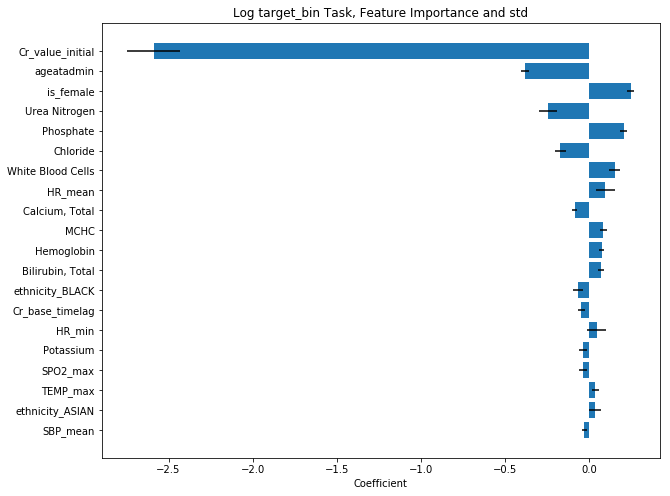

In [29]:


max_feat=20
model_name='Log'
target='target_bin'
get_feature_importance(feature_importance_all,model_name,target,max_feat,plot_CI=False)